# Fiche TP N° 03:

## MLP-32-16-8_CV

### Import the required libraries:

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from transformers import BertTokenizer, TFBertForSequenceClassification 
import tensorflow as tf

c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Data Loading & Preprocessing

In [2]:
df = pd.read_csv("preprocessed_data.csv")  

#clean dataset from ununsed features
df.drop(['id'],axis=1,inplace=True)

# Group the DataFrame by author and select the first 1000 rows for each author
df_sampled = df.groupby('author').head(1000)

# Concatenate the sampled DataFrames into a new DataFrame
df_new = pd.concat([df_sampled], ignore_index=True)

df_new.author.value_counts()

author
EAP    1000
HPL    1000
MWS    1000
Name: count, dtype: int64

### Encode The label Values

In [3]:
# Encode the author labels
encoder = LabelEncoder()
df_new['author_encoded'] = encoder.fit_transform(df_new['author'])

In [4]:
df_new

,text,author,author_encoded
0,proces however afforded means ascertaining dim...,EAP,0
1,never occurred fumbling might mere mistake,HPL,1
2,left hand gold snuff box capered hil cutting m...,EAP,0
3,lovely spring looked windsor terrace sixteen f...,MWS,2
4,finding nothing else even gold superintendent ...,HPL,1
...,...,...,...
2995,research work required prodigious supply fresh...,HPL,1
2996,told,HPL,1
2997,ye toil live life made beauty song,HPL,1
2998,yet prologue actual dunwich horor,HPL,1


### Text Tokenization:

#### BERT Tokenization:
 Type of tokenization called wordpiece tokenization handle both common and rare words effectively.

### Load the BERT tokenizer and model

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data Preparation

In [6]:
sentences = df_new['text'].values
labels = df_new['author_encoded'].values
labels

array([0, 1, 0, ..., 1, 1, 1])

### Input_ids represent the tokenized input text converted into numerical IDs according to the vocabulary
###  Attention_masks are binary masks that  allows the model to differentiate between real tokens and padding tokens, especially when processing input sequences of varying lengths. (consists of 1s and 0s, 1 for not considered as padding)

In [7]:
input_ids = [] 
attention_masks = []

In [8]:

for sent in sentences:
    # dictionary format that the BERT model can understand.
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True,
        max_length = 64,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'tf',
    )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
input_ids = tf.concat(input_ids, 0)
attention_masks = tf.concat(attention_masks, 0)
labels = tf.convert_to_tensor(labels)

### Split the data into train and validation sets

In [10]:
input_ids_np = np.array(input_ids)
labels_np = np.array(labels)
attention_masks_np = np.array(attention_masks)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids_np, labels_np, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks_np, labels_np, random_state=42, test_size=0.1)

In [11]:
train_inputs

array([[  101,  1052, 22346, ...,     0,     0,     0],
       [  101,  2056,  4847, ...,     0,     0,     0],
       [  101,  2279,  2851, ...,     0,     0,     0],
       ...,
       [  101, 16016,  2100, ...,     0,     0,     0],
       [  101, 25430, 12069, ...,     0,     0,     0],
       [  101,  2034,  8916, ...,     0,     0,     0]])

In [12]:
train_masks

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

### Train the Model

In [13]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )
model.fit([train_inputs, train_masks], train_labels, batch_size=32, epochs=3)
import matplotlib.pyplot as plt


Epoch 1/3


85/85 [==============================] - 1700s 19s/step - loss: 1.0322 - accuracy: 0.4700
Epoch 2/3
85/85 [==============================] - 1563s 18s/step - loss: 0.7984 - accuracy: 0.6600
Epoch 3/3
85/85 [==============================] - 1611s 19s/step - loss: 0.6056 - accuracy: 0.7689


NameError: name 'accuracy' is not defined

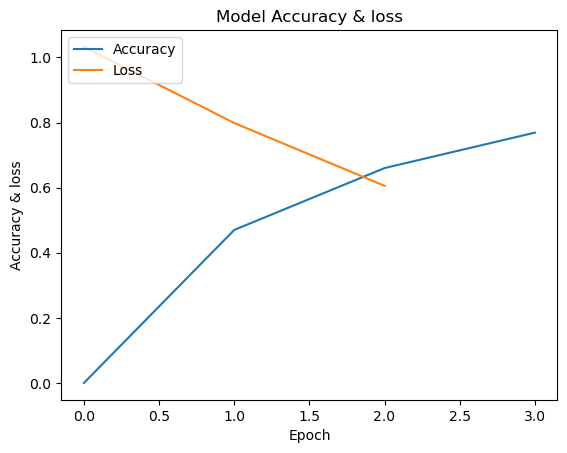

In [1]:
import matplotlib.pyplot as plt

# Define the training and validation accuracy and loss
train_3epochs_acc = [0,0.47, 0.66, 0.7689]
train_3epochs_loss = [1.0322, 0.7984, 0.6056]

# Plot the training and validation accuracy
plt.plot(train_3epochs_acc)
plt.plot(train_3epochs_loss)
plt.title('Model Accuracy & loss')
plt.ylabel('Accuracy & loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

### Model Evaluation

In [14]:
results = model.evaluate([validation_inputs, validation_masks], validation_labels)
print("test loss, test acc:", results)

10/10 [==============================] - 47s 4s/step - loss: 0.8346 - accuracy: 0.6433
test loss, test acc: [0.8346440196037292, 0.6433333158493042]


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
model2 = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=3)

model2.compile(
              optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )
model2.fit([train_inputs, train_masks], train_labels,callbacks=[early_stopping], batch_size=32, epochs=5)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
85/85 [==============================] - 1779s 20s/step - loss: 1.0482 - accuracy: 0.4493
Epoch 2/5
85/85 [==============================] - 1603s 19s/step - loss: 0.8030 - accuracy: 0.6567
Epoch 3/5
85/85 [==============================] - 1822s 21s/step - loss: 0.5836 - accuracy: 0.7811
Epoch 4/5
85/85 [==============================] - 1820s 21s/step - loss: 0.4137 - accuracy: 0.8544
Epoch 5/5
85/85 [==============================] - 1819s 21s/step - loss: 0.2772 - accuracy: 0.9104


In [16]:
results = model2.evaluate([validation_inputs, validation_masks], validation_labels)
print("test loss, test acc:", results)

10/10 [==============================] - 72s 6s/step - loss: 0.9045 - accuracy: 0.6733
test loss, test acc: [0.9045352935791016, 0.6733333468437195]


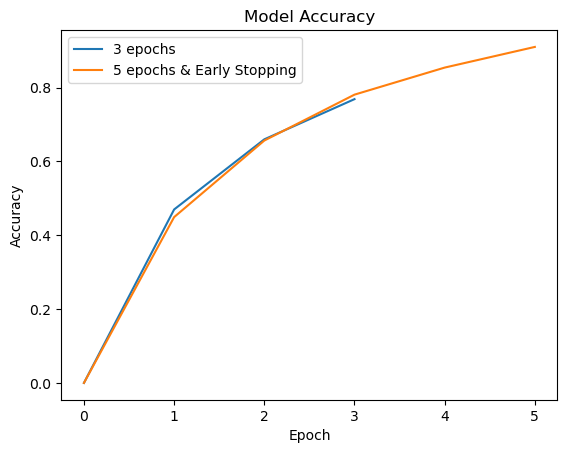

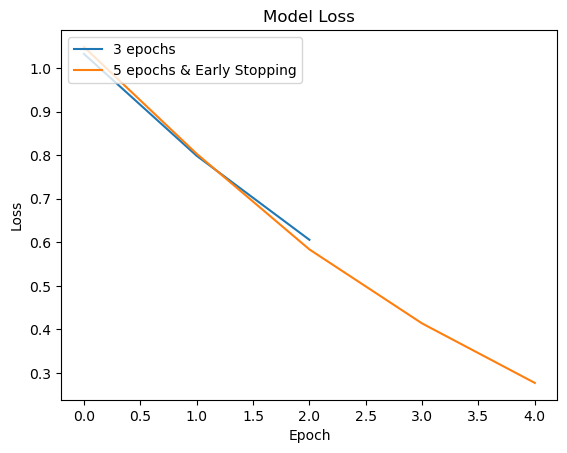

In [5]:
import matplotlib.pyplot as plt

# Define the training and validation accuracy and loss
train_3epochs_acc = [0,0.47, 0.66, 0.7689]
train_5epochs_acc = [0,0.4493, 0.6567, 0.7811, 0.8544, 0.9104]
train_3epochs_loss = [1.0322, 0.7984, 0.6056]
train_5epochs_loss = [1.0482, 0.8030, 0.5836 , 0.4137, 0.2772]

# Plot the training and validation accuracy
plt.plot(train_3epochs_acc)
plt.plot(train_5epochs_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['3 epochs', '5 epochs & Early Stopping'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(train_3epochs_loss)
plt.plot(train_5epochs_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['3 epochs', '5 epochs & Early Stopping'], loc='upper left')
plt.show()

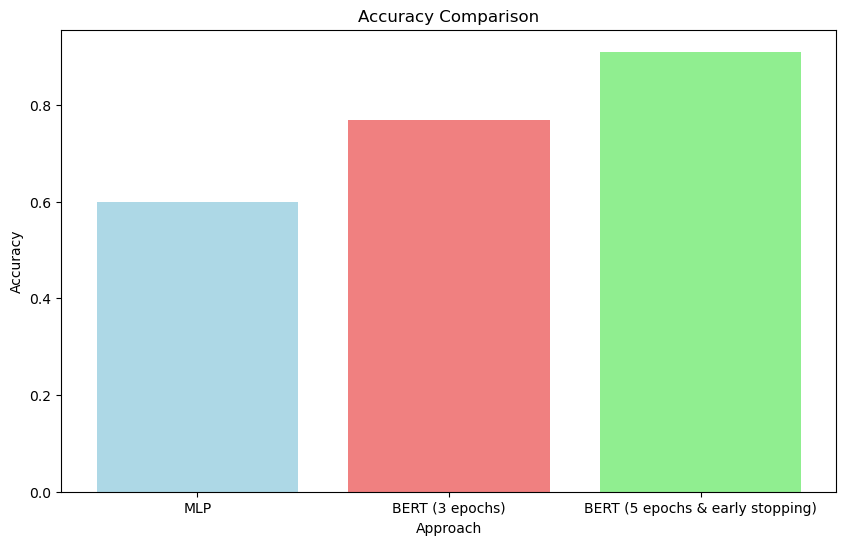

In [9]:
import matplotlib.pyplot as plt

# Define the approaches and their accuracies
approaches = ['MLP', 'BERT (3 epochs)', 'BERT (5 epochs & early stopping)']
accuracies = [0.60, 0.7689, 0.91]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(approaches, accuracies, color=['lightblue', 'lightcoral', 'lightgreen'])
plt.title('Accuracy Comparison')
plt.xlabel('Approach')
plt.ylabel('Accuracy')

plt.show()

# CNN Text Classification

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Data preprocessing & cleaning

In [4]:
df = pd.read_csv("preprocessed_data.csv")  

df.drop(['id'],axis=1,inplace=True)

df_sampled = df.groupby('author').head(1000)

# Concatenate the sampled DataFrames into a new DataFrame
df_new = pd.concat([df_sampled], ignore_index=True)

In [5]:
df_new

,text,author
0,proces however afforded means ascertaining dim...,EAP
1,never occurred fumbling might mere mistake,HPL
2,left hand gold snuff box capered hil cutting m...,EAP
3,lovely spring looked windsor terrace sixteen f...,MWS
4,finding nothing else even gold superintendent ...,HPL
...,...,...
2995,research work required prodigious supply fresh...,HPL
2996,told,HPL
2997,ye toil live life made beauty song,HPL
2998,yet prologue actual dunwich horor,HPL


### Label Encoding

In [6]:
encoder = LabelEncoder()
df_new['author_encoded'] = encoder.fit_transform(df_new['author'])
df_new

,text,author,author_encoded
0,proces however afforded means ascertaining dim...,EAP,0
1,never occurred fumbling might mere mistake,HPL,1
2,left hand gold snuff box capered hil cutting m...,EAP,0
3,lovely spring looked windsor terrace sixteen f...,MWS,2
4,finding nothing else even gold superintendent ...,HPL,1
...,...,...,...
2995,research work required prodigious supply fresh...,HPL,1
2996,told,HPL,1
2997,ye toil live life made beauty song,HPL,1
2998,yet prologue actual dunwich horor,HPL,1


### Tokenization And pad Sequences
we use pad_sequences to ensure that all sequences in a list have the same length. 

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_new['text'])
sequences = tokenizer.texts_to_sequences(df_new['text'])
data = pad_sequences(sequences, maxlen=200)

### Data Split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(data, df_new['author_encoded'], test_size=0.2, random_state=42)

### Model Defining

In [16]:
model = Sequential()
model.add(layers.Embedding(input_dim=5000, output_dim=50, input_length=200))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 50)           250000    
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          32128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 283451 (1.08 MB)
Trainable params: 283451 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

### Early Stopping Defining

In [21]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model Training

In [22]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=64, callbacks=[early_stopping])

Epoch 1/10
38/38 [==============================] - 2s 48ms/step - loss: 0.0092 - accuracy: 0.9987 - val_loss: 1.1003 - val_accuracy: 0.7083
Epoch 2/10
38/38 [==============================] - 2s 45ms/step - loss: 0.0080 - accuracy: 0.9987 - val_loss: 1.1276 - val_accuracy: 0.7067
Epoch 3/10
38/38 [==============================] - 2s 44ms/step - loss: 0.0065 - accuracy: 0.9987 - val_loss: 1.1637 - val_accuracy: 0.7083
Epoch 4/10
38/38 [==============================] - 2s 43ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 1.1953 - val_accuracy: 0.7067


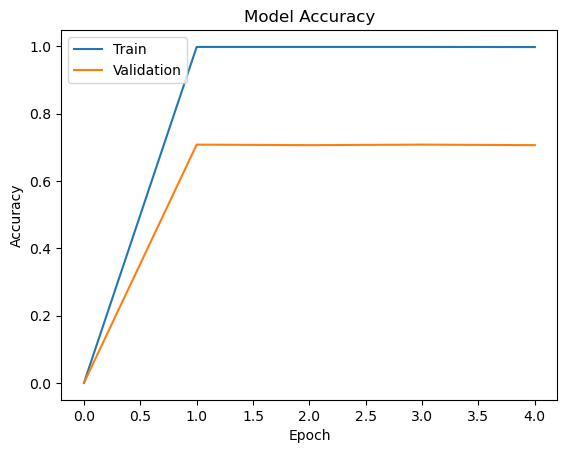

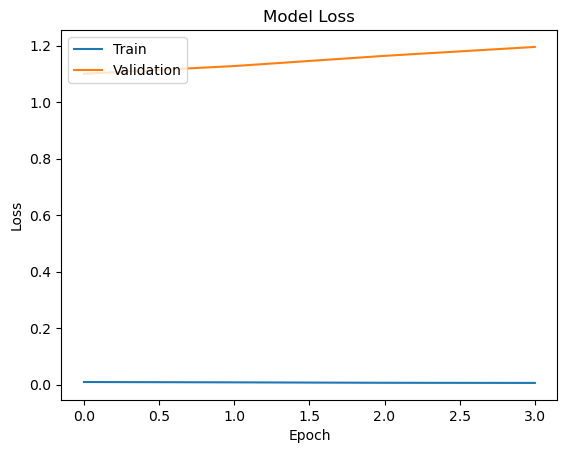

In [28]:
import matplotlib.pyplot as plt

# Define the training and validation accuracy and loss
train_CNN_acc = [0,0.9987, 0.9987, 0.9987, 0.9983]
Val_CNN_acc = [0,0.7083, 0.7067, 0.7083, 0.7067]
tain_CNN_loss = [0.0092, 0.0080, 0.0065, 0.0060]
Val_Cnn_loss = [1.1003, 1.1276 , 1.1637 , 1.1953]

# Plot the training and validation accuracy
plt.plot(train_CNN_acc)
plt.plot(Val_CNN_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(tain_CNN_loss)
plt.plot(Val_Cnn_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

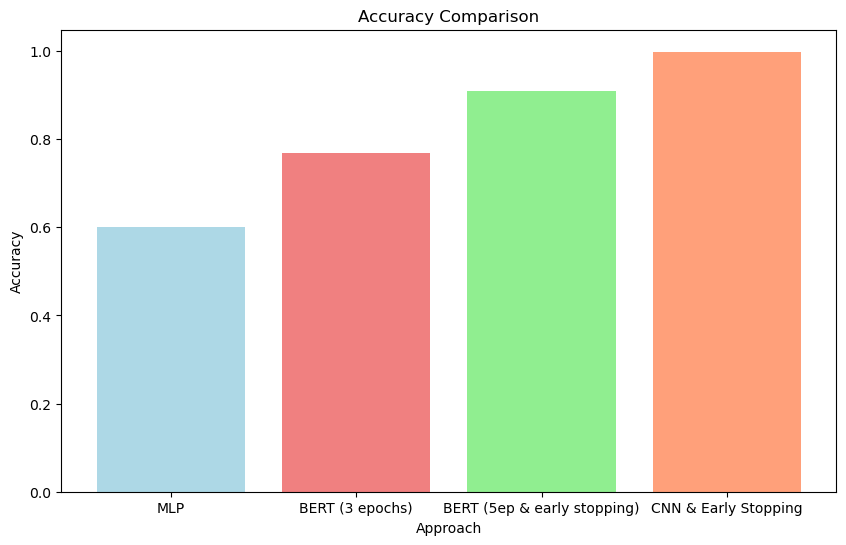

In [24]:
import matplotlib.pyplot as plt

# Define the approaches and their accuracies
approaches = ['MLP', 'BERT (3 epochs)', 'BERT (5ep & early stopping)', 'CNN & Early Stopping']
accuracies = [0.60, 0.7689, 0.91, 0.9982]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(approaches, accuracies, color=['lightblue', 'lightcoral', 'lightgreen', 'LightSalmon'])
plt.title('Accuracy Comparison')
plt.xlabel('Approach')
plt.ylabel('Accuracy')

plt.show()